# Detection of AI-Generated Arabic Text (KFUPM-JRCAI/arabic-generated-abstracts)

This notebook follows the course project phases (1 → 5) in the simplest possible way:
- HF dataset load
- Arabic preprocessing + EDA
- TF-IDF + assigned stylometry (1, 24, 47, 70, 93)
- Traditional models (NB / LR / SVM) + proper evaluation (incl. balanced accuracy)
- Optional deep model: MLP on Arabic BERT embeddings
- Final comparison + error analysis + feature importance

**Label convention:** `0 = HUMAN`, `1 = AI`

In [1]:
# =========================
# Phase 1: Setup + Data Acquisition
# =========================

import os
import numpy as np
import pandas as pd

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# (Optional) if running on Colab and you need deps:
# !pip -q install datasets transformers torch arabic-reshaper python-bidi

from datasets import load_dataset

DATASET_NAME = "KFUPM-JRCAI/arabic-generated-abstracts"
ds = load_dataset(DATASET_NAME)

print(ds)
print("Splits:", list(ds.keys()))

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    by_polishing: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2851
    })
    from_title: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2963
    })
    from_title_and_content: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2574
    })
})
Splits: ['by_polishing', 'from_title', 'from_title_and_content']


In [2]:
# Convert HF dataset -> a single dataframe with columns: text, label, source
# Each original_abstract becomes (label=0) + each generated_abstract becomes (label=1)

def hf_to_binary_df(hf_split):
    df = hf_split.to_pandas()
    cols = list(df.columns)

    # Identify human + AI fields (robust to naming changes)
    human_col = "original_abstract" if "original_abstract" in cols else None
    ai_cols = [c for c in cols if c.endswith("_generated_abstract")]

    if human_col is None:
        raise ValueError(f"Cannot find 'original_abstract' in columns: {cols}")
    if not ai_cols:
        raise ValueError(f"Cannot find '*_generated_abstract' columns in columns: {cols}")

    rows = []
    for _, r in df.iterrows():
        # human
        rows.append({"text": r[human_col], "label": 0, "source": "human"})
        # ai (one row per model)
        for c in ai_cols:
            rows.append({"text": r[c], "label": 1, "source": c.replace("_generated_abstract","")})

    out = pd.DataFrame(rows)
    out["text"] = out["text"].astype(str)
    out = out.dropna(subset=["text"]).drop_duplicates(subset=["text","label"])
    return out

# Use the HF splits if provided; otherwise do our own split later.
if "train" in ds and "validation" in ds and "test" in ds:
    train_df = hf_to_binary_df(ds["train"])
    val_df   = hf_to_binary_df(ds["validation"])
    test_df  = hf_to_binary_df(ds["test"])
else:
    full_df = pd.concat([hf_to_binary_df(ds[s]) for s in ds.keys()], ignore_index=True)
    train_df, val_df, test_df = None, None, None
    print("HF does not provide (train/validation/test) explicitly. We'll split in the next cell.")

print("Train/Val/Test sizes:", 
      None if train_df is None else len(train_df),
      None if val_df   is None else len(val_df),
      None if test_df  is None else len(test_df))

HF does not provide (train/validation/test) explicitly. We'll split in the next cell.
Train/Val/Test sizes: None None None


In [3]:
# If splits were not provided by HF: create 70/15/15 split (done BEFORE any preprocessing)
from sklearn.model_selection import train_test_split

if train_df is None:
    full_df = full_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    train_df, tmp_df = train_test_split(
        full_df, test_size=0.30, random_state=RANDOM_SEED, stratify=full_df["label"]
    )
    val_df, test_df = train_test_split(
        tmp_df, test_size=0.50, random_state=RANDOM_SEED, stratify=tmp_df["label"]
    )

    train_df = train_df.reset_index(drop=True)
    val_df   = val_df.reset_index(drop=True)
    test_df  = test_df.reset_index(drop=True)

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Train label balance:", train_df["label"].value_counts(normalize=True).to_dict())

Split sizes: 29355 6291 6291
Train label balance: {1: 0.8, 0: 0.2}


In [4]:
# Quick data quality checks (missing, duplicates)
for name, df in [("train",train_df), ("val",val_df), ("test",test_df)]:
    print(f"--- {name} ---")
    print("missing text:", df["text"].isna().sum())
    print("dup rows (text,label):", df.duplicated(subset=["text","label"]).sum())

--- train ---
missing text: 0
dup rows (text,label): 2992
--- val ---
missing text: 0
dup rows (text,label): 160
--- test ---
missing text: 0
dup rows (text,label): 177


## Phase 2: Preprocessing + EDA

Notes:
- Use `text_eda` for EDA (light normalisation; keeps readability)
- Use `text_clean` for modelling (stemmed)
- WordCloud removed (Arabic rendering issues).

In [5]:
# =========================
# Phase 2: Preprocessing
# =========================

import sys
sys.path.append("..")

from src.data_preparation import preprocess_text, add_stylometry

# Lightly cleaned for EDA (no stemming)
train_df["text_eda"] = train_df["text"].apply(lambda t: preprocess_text(t, do_stem=False))
val_df["text_eda"]   = val_df["text"].apply(lambda t: preprocess_text(t, do_stem=False))
test_df["text_eda"]  = test_df["text"].apply(lambda t: preprocess_text(t, do_stem=False))

# Clean for modelling (stemmed)
train_df["text_clean"] = train_df["text"].apply(lambda t: preprocess_text(t, do_stem=True))
val_df["text_clean"]   = val_df["text"].apply(lambda t: preprocess_text(t, do_stem=True))
test_df["text_clean"]  = test_df["text"].apply(lambda t: preprocess_text(t, do_stem=True))

train_df[["text","text_clean","text_eda","label"]].head()

,text,text_clean,text_eda,label
0,هدف الدراسة إلى:معرفة دور وسائل الإعلام في تحر...,هدف درس :معرف دور سيل علم حرض جمهور علي مرس عن...,هدف الدراسه الي:معرفه دور وسايل الاعلام تحريض ...,0
1,يستكشف هذا البحث دور البيانات الشعرية الحديثة ...,كشف بحث دور بين شعر حدث شكل خطب شعر عرب معاصر،...,يستكشف البحث دور البيانات الشعريه الحديثه تشكي...,1
2,تلعب الجامعات دورًا محوريًا في تعزيز التنمية ا...,لعب جمع دور حور عزز نمه بشر اجتماعيه عبر جهز ف...,تلعب الجامعات دورا محوريا تعزيز التنميه البشري...,1
3,تسعى هذه الدراسة إلى استكشاف ظاهرة تزايد الانف...,تسع درس الي كشف ظهر زيد فاق عام جزاير، عبر ظهر...,تسعي الدراسه الي استكشاف ظاهره تزايد الانفاق ا...,1
4,تدرس هذه الدراسة آفاق وتحديات الاتصال التنظيمي...,درس درس افق تحد تصل نظم بيه رقميه، ركز علي كيف...,تدرس الدراسه افاق وتحديات الاتصال التنظيمي الب...,1


In [6]:
# =========================
# Phase 2: EDA (stats + ngrams + function words + punctuation)
# =========================

import re
from collections import Counter
import numpy as np
import pandas as pd

sent_split = re.compile(r"[\.\!\?؟]+")
token_re = re.compile(r"\S+")

def avg_word_len(s):
    toks = token_re.findall(str(s))
    return float(np.mean([len(t) for t in toks])) if toks else 0.0

def avg_sent_len_words(s):
    parts = [p.strip() for p in sent_split.split(str(s)) if p.strip()]
    if not parts:
        return 0.0
    lens = [len(token_re.findall(p)) for p in parts]
    return float(np.mean(lens))

def ttr(s):
    toks = token_re.findall(str(s))
    return (len(set(toks))/len(toks)) if toks else 0.0

eda_rows = []
for lab in [0, 1]:
    sub = train_df.loc[train_df["label"]==lab, "text_eda"]
    eda_rows.append({
        "label": lab,
        "n": int(len(sub)),
        "avg_word_len": float(np.mean(sub.apply(avg_word_len))),
        "avg_sent_len_words": float(np.mean(sub.apply(avg_sent_len_words))),
        "avg_ttr": float(np.mean(sub.apply(ttr))),
    })

pd.DataFrame(eda_rows)

,label,n,avg_word_len,avg_sent_len_words,avg_ttr
0,0,5871,5.730756,48.533103,0.862676
1,1,23484,5.924669,18.257387,0.829948


In [7]:
# Top n-grams (TF-IDF inspection only)
from sklearn.feature_extraction.text import TfidfVectorizer

def top_ngrams(texts, ngram_range=(1,2), topk=20):
    vec = TfidfVectorizer(ngram_range=ngram_range, max_features=20000, min_df=2)
    X = vec.fit_transform(texts.astype(str))
    scores = np.asarray(X.mean(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    idx = np.argsort(scores)[::-1][:topk]
    return list(zip(vocab[idx], scores[idx]))

print("HUMAN top n-grams:")
print(top_ngrams(train_df.loc[train_df["label"]==0, "text_eda"]))

print("\nAI top n-grams:")
print(top_ngrams(train_df.loc[train_df["label"]==1, "text_eda"]))

HUMAN top n-grams:
[('علي', np.float64(0.03539145825782383)), ('الي', np.float64(0.02944503598990335)), ('ان', np.float64(0.023516633653997386)), ('الدراسه', np.float64(0.01895405917722985)), ('خلال', np.float64(0.015394384382336075)), ('البحث', np.float64(0.010993322366625556)), ('العربيه', np.float64(0.010855180511958898)), ('الجزاير', np.float64(0.010052123552258433)), ('اللغه', np.float64(0.009533726729651006)), ('وقد', np.float64(0.009475107897167835)), ('الجزايري', np.float64(0.00906226451482458)), ('الدراسه الي', np.float64(0.008623244481899453)), ('اهم', np.float64(0.008108117339992739)), ('الا', np.float64(0.008095622686009565)), ('وذلك', np.float64(0.008005078769586706)), ('النص', np.float64(0.007989137341438917)), ('كانت', np.float64(0.007184123880180173)), ('خاصه', np.float64(0.0071739857928364145)), ('المجتمع', np.float64(0.007099827449498519)), ('تم', np.float64(0.007030523209096041))]

AI top n-grams:
[('علي', np.float64(0.039885388558027715)), ('الي', np.float64(0.03190

In [8]:
# Function words + punctuation quick check
func_words = ["و","في","من","على","الى","إلى","عن","لكن","او","أو","ثم","قد","لم","لن","ما","لا","هذا","هذه","ذلك","تلك"]
puncts = list(".,!?:;،؟؛…")

def freq_table(texts, vocab):
    cnt = Counter()
    for t in texts.astype(str):
        for w in t.split():
            if w in vocab:
                cnt[w] += 1
    total = sum(cnt.values()) if cnt else 1
    return (pd.DataFrame({"token": list(cnt.keys()), "count": list(cnt.values())})
              .assign(ratio=lambda d: d["count"]/total)
              .sort_values("count", ascending=False))

def punct_counts(texts):
    cnt = Counter()
    for t in texts.astype(str):
        for ch in t:
            if ch in puncts:
                cnt[ch] += 1
    return (pd.DataFrame({"punct": list(cnt.keys()), "count": list(cnt.values())})
              .sort_values("count", ascending=False))

print("Function words (HUMAN):")
display(freq_table(train_df.loc[train_df["label"]==0, "text_eda"], set(func_words)).head(15))

print("Function words (AI):")
display(freq_table(train_df.loc[train_df["label"]==1, "text_eda"], set(func_words)).head(15))

print("Punctuation counts (HUMAN):")
display(punct_counts(train_df.loc[train_df["label"]==0, "text"]))

print("Punctuation counts (AI):")
display(punct_counts(train_df.loc[train_df["label"]==1, "text"]))

Function words (HUMAN):


,token,count,ratio


Function words (AI):


,token,count,ratio


Punctuation counts (HUMAN):


,punct,count
2,،,40091
1,.,18832
0,:,2476
3,؛,1605
5,",",672
4,؟,515
8,;,20
7,…,8
6,!,5


Punctuation counts (AI):


,punct,count
1,.,113222
0,،,113167
2,:,3664
3,؛,342
4,؟,328
5,",",171
6,;,20
7,?,3


## Phase 3: Feature Engineering (TF-IDF + assigned stylometry)

Assigned features: **1, 24, 47, 70, 93**  
We compute stylometry on the original `text` (not stemmed).

In [9]:
# =========================
# Phase 3: Feature Engineering
# =========================

from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Stylometry on original text
train_df = add_stylometry(train_df, text_col="text")
val_df   = add_stylometry(val_df,   text_col="text")
test_df  = add_stylometry(test_df,  text_col="text")

# Robust column mapping (because f24 name can differ depending on implementation)
styl_candidates = [
    "f1_total_chars",
    "f24_unique_punct_ratio",      # older name
    "f24_diff_punct_over_C",       # your current implementation
    "f47_pronoun_count",
    "f70_first_person_count",
    "f93_arousal_mean",
]
avail = set(train_df.columns)

# Pick the actual f24 column available
f24_col = "f24_diff_punct_over_C" if "f24_diff_punct_over_C" in avail else "f24_unique_punct_ratio"

styl_cols = [
    "f1_total_chars",
    f24_col,
    "f47_pronoun_count",
    "f70_first_person_count",
    "f93_arousal_mean",
]

print("Stylometry columns used:", styl_cols)
display(train_df[styl_cols].head())

# TF-IDF on stemmed text_clean (fit TRAIN only)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=60000, min_df=2)
Xtr_tfidf = tfidf.fit_transform(train_df["text_clean"])
Xva_tfidf = tfidf.transform(val_df["text_clean"])
Xte_tfidf = tfidf.transform(test_df["text_clean"])

# Scale stylometry (fit TRAIN only)
scaler = StandardScaler()
Xtr_style = scaler.fit_transform(train_df[styl_cols].values)
Xva_style = scaler.transform(val_df[styl_cols].values)
Xte_style = scaler.transform(test_df[styl_cols].values)

# Combine
Xtr = hstack([Xtr_tfidf, csr_matrix(Xtr_style)])
Xva = hstack([Xva_tfidf, csr_matrix(Xva_style)])
Xte = hstack([Xte_tfidf, csr_matrix(Xte_style)])

ytr = train_df["label"].values
yva = val_df["label"].values
yte = test_df["label"].values

print("Shapes:", Xtr.shape, Xva.shape, Xte.shape)
print("Train label balance:", np.bincount(ytr) / len(ytr))

Stylometry columns used: ['f1_total_chars', 'f24_diff_punct_over_C', 'f47_pronoun_count', 'f70_first_person_count', 'f93_arousal_mean']


,f1_total_chars,f24_diff_punct_over_C,f47_pronoun_count,f70_first_person_count,f93_arousal_mean
0,1052.0,0.002852,1.0,0.0,0.0
1,392.0,0.005102,0.0,0.0,0.0
2,942.0,0.002123,0.0,0.0,0.0
3,923.0,0.002167,0.0,0.0,0.0
4,287.0,0.013937,0.0,0.0,0.0


Shapes: (29355, 60005) (6291, 60005) (6291, 60005)
Train label balance: [0.2 0.8]


## Phase 4: Model Building + Evaluation

Models:
- NB baseline (TF-IDF only)
- Logistic Regression (TF-IDF + stylometry) + tuned threshold
- Linear SVM + calibration (TF-IDF + stylometry) + tuned threshold

We keep everything in a single `results` dict, including:
- metrics (`val`, `test`)
- confusion matrix (`cm_test`)
- `test_score` (probability/score of class=1)
- `test_pred` (final prediction using threshold)

In [10]:
# =========================
# Phase 4: Helpers (metrics + threshold tuning)
# =========================

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    balanced_accuracy_score,
    confusion_matrix
)

def compute_metrics_local(y_true, y_pred, scores=None):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

    auc = None
    if scores is not None:
        try:
            auc = roc_auc_score(y_true, scores)
        except Exception:
            auc = None

    return {
        "accuracy": float(acc),
        "balanced_accuracy": float(bacc),
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
        "roc_auc": None if auc is None else float(auc),
    }

def tune_threshold_by_val_bacc(y_true_val, scores_val, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 37)
    best_thr, best_bacc = 0.50, -1.0
    for thr in grid:
        pred = (scores_val >= thr).astype(int)
        bacc = balanced_accuracy_score(y_true_val, pred)
        if bacc > best_bacc:
            best_bacc, best_thr = bacc, thr
    return float(best_thr), float(best_bacc)

In [11]:
# =========================
# Phase 4: Models
# =========================

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

results = {}

# ---- 4.1 NB baseline (TF-IDF only) ----
nb = MultinomialNB(alpha=0.5)
nb.fit(Xtr_tfidf, ytr)

nb_val_score  = nb.predict_proba(Xva_tfidf)[:, 1]
nb_test_score = nb.predict_proba(Xte_tfidf)[:, 1]
nb_val_pred   = (nb_val_score  >= 0.50).astype(int)
nb_test_pred  = (nb_test_score >= 0.50).astype(int)

results["NB_baseline"] = {
    "best_thr_val": 0.50,
    "val": compute_metrics_local(yva, nb_val_pred, nb_val_score),
    "test": compute_metrics_local(yte, nb_test_pred, nb_test_score),
    "test_score": nb_test_score,
    "test_pred": nb_test_pred,
    "cm_test": confusion_matrix(yte, nb_test_pred),
}

print("NB (TEST):", results["NB_baseline"]["test"])

# ---- 4.2 Logistic Regression (TF-IDF + stylometry) ----
best_lr, best_auc = None, -1
for C in [0.5, 1.0, 2.0, 4.0]:
    lr = LogisticRegression(max_iter=2000, C=C, solver="liblinear")
    lr.fit(Xtr, ytr)
    val_score = lr.predict_proba(Xva)[:, 1]
    val_pred  = (val_score >= 0.50).astype(int)
    m = compute_metrics_local(yva, val_pred, val_score)
    auc = m["roc_auc"] if m["roc_auc"] is not None else m["f1"]
    if auc > best_auc:
        best_auc = auc
        best_lr = lr

lr_model = best_lr

lr_val_score  = lr_model.predict_proba(Xva)[:, 1]
lr_test_score = lr_model.predict_proba(Xte)[:, 1]

# default thr=0.50
lr_val_pred_05  = (lr_val_score  >= 0.50).astype(int)
lr_test_pred_05 = (lr_test_score >= 0.50).astype(int)

results["LogReg"] = {
    "best_thr_val": 0.50,
    "val": compute_metrics_local(yva, lr_val_pred_05, lr_val_score),
    "test": compute_metrics_local(yte, lr_test_pred_05, lr_test_score),
    "test_score": lr_test_score,
    "test_pred": lr_test_pred_05,
    "cm_test": confusion_matrix(yte, lr_test_pred_05),
}

# tune threshold by VAL balanced accuracy
lr_thr, lr_val_bacc = tune_threshold_by_val_bacc(yva, lr_val_score)
lr_val_pred_thr  = (lr_val_score  >= lr_thr).astype(int)
lr_test_pred_thr = (lr_test_score >= lr_thr).astype(int)

results["LogReg_tunedThr"] = {
    "best_thr_val": lr_thr,
    "val_bacc": lr_val_bacc,
    "val": compute_metrics_local(yva, lr_val_pred_thr, lr_val_score),
    "test": compute_metrics_local(yte, lr_test_pred_thr, lr_test_score),
    "test_score": lr_test_score,
    "test_pred": lr_test_pred_thr,
    "cm_test": confusion_matrix(yte, lr_test_pred_thr),
}

print("LogReg (TEST):", results["LogReg"]["test"])
print("LogReg tuned thr:", lr_thr, "| TEST:", results["LogReg_tunedThr"]["test"])

# ---- 4.3 Linear SVM + calibration (probabilities) ----
svm_base = LinearSVC(C=1.0, max_iter=20000)
svm = CalibratedClassifierCV(svm_base, method="sigmoid", cv=3)
svm.fit(Xtr, ytr)

svm_val_score  = svm.predict_proba(Xva)[:, 1]
svm_test_score = svm.predict_proba(Xte)[:, 1]

svm_val_pred_05  = (svm_val_score  >= 0.50).astype(int)
svm_test_pred_05 = (svm_test_score >= 0.50).astype(int)

results["LinearSVM"] = {
    "best_thr_val": 0.50,
    "val": compute_metrics_local(yva, svm_val_pred_05, svm_val_score),
    "test": compute_metrics_local(yte, svm_test_pred_05, svm_test_score),
    "test_score": svm_test_score,
    "test_pred": svm_test_pred_05,
    "cm_test": confusion_matrix(yte, svm_test_pred_05),
}

svm_thr, svm_val_bacc = tune_threshold_by_val_bacc(yva, svm_val_score)
svm_val_pred_thr  = (svm_val_score  >= svm_thr).astype(int)
svm_test_pred_thr = (svm_test_score >= svm_thr).astype(int)

results["LinearSVM_tunedThr"] = {
    "best_thr_val": svm_thr,
    "val_bacc": svm_val_bacc,
    "val": compute_metrics_local(yva, svm_val_pred_thr, svm_val_score),
    "test": compute_metrics_local(yte, svm_test_pred_thr, svm_test_score),
    "test_score": svm_test_score,
    "test_pred": svm_test_pred_thr,
    "cm_test": confusion_matrix(yte, svm_test_pred_thr),
}

print("LinearSVM (TEST):", results["LinearSVM"]["test"])
print("LinearSVM tuned thr:", svm_thr, "| TEST:", results["LinearSVM_tunedThr"]["test"])

NB (TEST): {'accuracy': 0.9373708472420919, 'balanced_accuracy': 0.8637754116308525, 'precision': 0.9383742911153119, 'recall': 0.9864864864864865, 'f1': 0.9618291028870374, 'roc_auc': 0.9838057085960419}
LogReg (TEST): {'accuracy': 0.9844221904307742, 'balanced_accuracy': 0.9786490369498593, 'precision': 0.9922186751795691, 'recall': 0.988275039745628, 'f1': 0.9902429311031462, 'roc_auc': 0.9963147689576227}
LogReg tuned thr: 0.5499999999999999 | TEST: {'accuracy': 0.9826736607852488, 'balanced_accuracy': 0.9793426912872785, 'precision': 0.9933854479855683, 'recall': 0.9848966613672496, 'f1': 0.9891228420317334, 'roc_auc': 0.9963147689576227}
LinearSVM (TEST): {'accuracy': 0.9868065490383087, 'balanced_accuracy': 0.9846061457663804, 'precision': 0.9951971182709626, 'recall': 0.988275039745628, 'f1': 0.9917240003988433, 'roc_auc': 0.9965666912064614}
LinearSVM tuned thr: 0.65 | TEST: {'accuracy': 0.9828326180257511, 'balanced_accuracy': 0.9862909152669934, 'precision': 0.99797734627831

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
# =========================
# Phase 4: Summary table (traditional)
# =========================

summary = []
for name, res in results.items():
    test = res["test"]
    summary.append({
        "model": name,
        "test_accuracy": test["accuracy"],
        "test_balanced_accuracy": test["balanced_accuracy"],
        "test_precision": test["precision"],
        "test_recall": test["recall"],
        "test_f1": test["f1"],
        "test_roc_auc": test["roc_auc"],
    })

df_summary = pd.DataFrame(summary).sort_values(
    ["test_balanced_accuracy", "test_roc_auc", "test_f1"],
    ascending=False
)

df_summary.round(4)

,model,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_roc_auc
4,LinearSVM_tunedThr,0.9828,0.9863,0.9980,0.9805,0.9892,0.9966
3,LinearSVM,0.9868,0.9846,0.9952,0.9883,0.9917,0.9966
2,LogReg_tunedThr,0.9827,0.9793,0.9934,0.9849,0.9891,0.9963
1,LogReg,0.9844,0.9786,0.9922,0.9883,0.9902,0.9963
0,NB_baseline,0.9374,0.8638,0.9384,0.9865,0.9618,0.9838


## Phase 4: Best model plots + error analysis

This uses only what is stored inside `results` (no manual variable mapping).

Best by VAL: LinearSVM | 0.9961173583443076


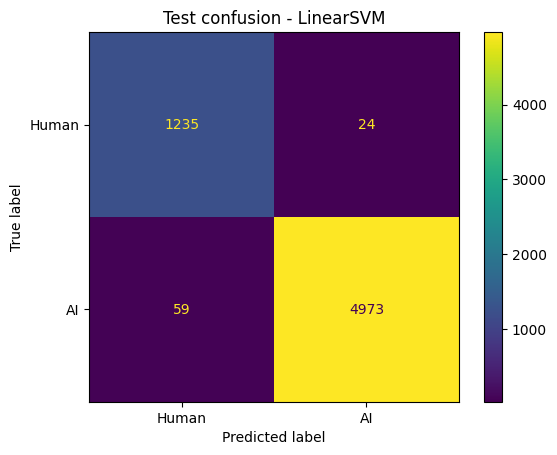

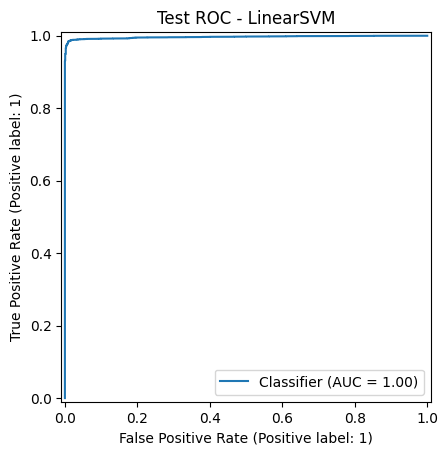


Wrong examples (first 10):
- true=1 pred=0 score=0.001 | يحتل مفهوم القيم في العلوم الاجتماعية أهمية كبيرة باعتباره محددا هاما من محددات السلوك البشري، وتعتبر القيم كذاك من أكثر السمات تأثرا بالإطار الثقافي والاجتماعي لطل مجتمع، فلكل مجتمع نسقه القيمي الخاص ويتغير هذا النسق تبعا لما يحصل في هذا المجتمع من  ...
- true=1 pred=0 score=0.003 | قبل تفنيد الأخطاء الواردة في الكتاب، يجب فحص صور المخطوط التي قدمها مدعي التحقيق. وقد عرض المؤلف في بداية كتابه وثائق المرابطين صورا من المخطوط الذي اعتمد عليه، وذكر (ص:236) "قمت بتصويرها من معهد الدراسات الإسلامية بمدريد (إسبانيا)؛ حيث واجهت صعوبة ك ...
- true=1 pred=0 score=0.005 | يشهد عصرنا الحالي مرحلة تقلصت فيها المسافة والمدة الزمنية بين ما تقدمه العلوم النظرية والتطبيقية؛ إذ لا تكاد تتبلور نظرية أو معرفة معينة حتى تجد طريقا نحو الاستفادة والتطبيق والانتشار، وهذا التطبيق هو الذي يرفع من المصداقية العلمية لتلك النظرية، أو ي ...
- true=1 pred=0 score=0.006 | شكّلت المعرفة اللّسانيّة ثورة فكريّة تبوّأت بها مركز الصدارة، وأصبحت قطب الرحى في المعر

In [13]:
from src.visualization import plot_confusion, plot_roc

# pick best by validation ROC-AUC if available else F1 (simple)
def pick_best_by_val_simple(results_dict):
    best_name, best_score = None, -1
    for k, res in results_dict.items():
        val = res.get("val", {})
        s = val.get("roc_auc", None)
        if s is None:
            s = val.get("f1", -1)
        if s is None:
            s = -1
        if s > best_score:
            best_score = s
            best_name = k
    return best_name, best_score

best_name, best_val = pick_best_by_val_simple(results)
print("Best by VAL:", best_name, "|", best_val)

best = results[best_name]
cm = best["cm_test"]
scores = np.asarray(best["test_score"]).ravel()
preds  = np.asarray(best["test_pred"]).ravel()

plot_confusion(cm, title=f"Test confusion - {best_name}")
plot_roc(yte, scores, title=f"Test ROC - {best_name}")

# Wrong examples: most confident mistakes
test_view = test_df.copy()
test_view["pred"] = preds
test_view["score"] = scores
wrong = test_view[test_view["pred"] != test_view["label"]].copy()
wrong["confidence"] = (wrong["score"] - 0.5).abs()
wrong = wrong.sort_values("confidence", ascending=False)

print("\nWrong examples (first 10):")
for _, row in wrong.head(10).iterrows():
    txt = str(row["text"]).replace("\n", " ")
    txt = (txt[:250] + " ...") if len(txt) > 250 else txt
    print(f"- true={row['label']} pred={row['pred']} score={row['score']:.3f} | {txt}")

## Phase 5: Interpretation + (optional) Deep Learning

Part A: Feature importance for the best *traditional* model  
Part B: MLP on BERT embeddings (optional DL requirement)

Best traditional (VAL bAcc): LinearSVM_tunedThr | 0.9847995282013118


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


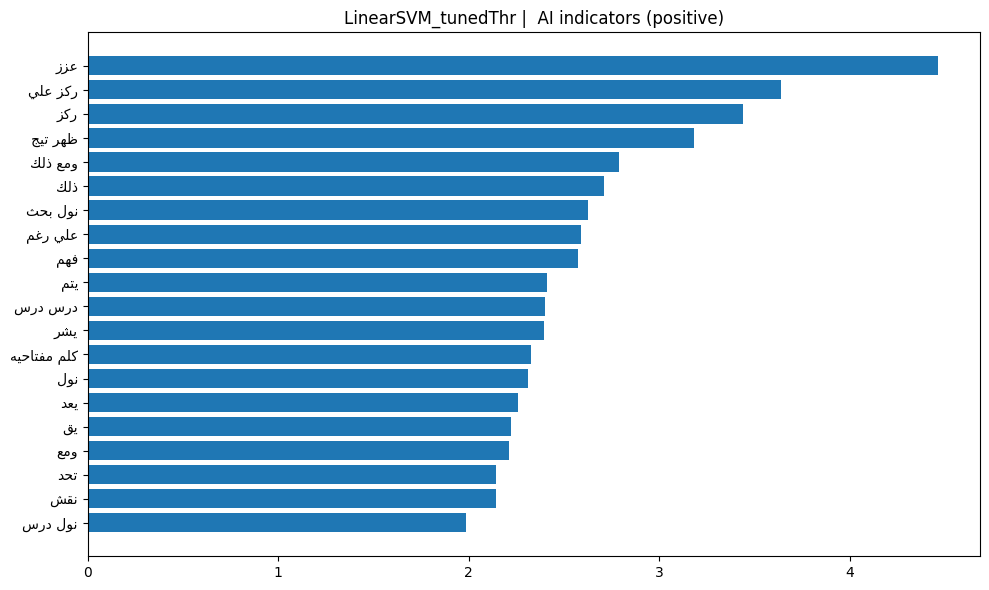

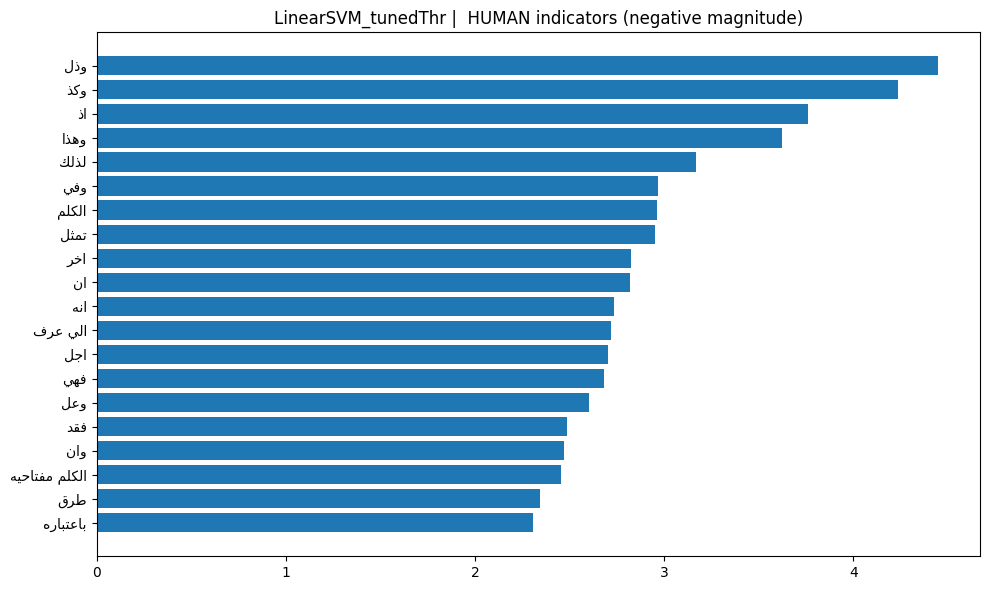

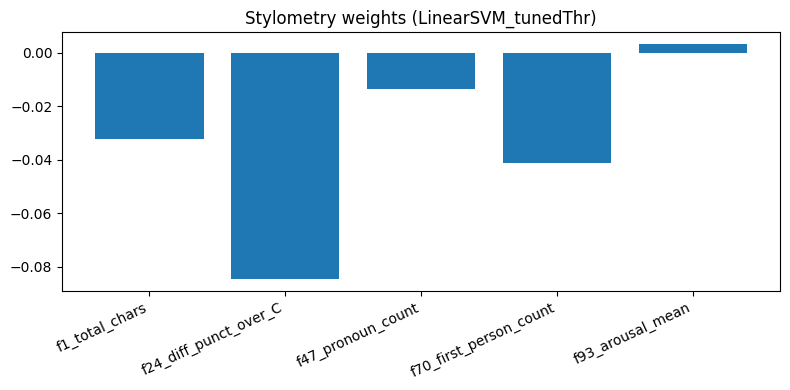

Stylometry weights:
- f1_total_chars: -0.032326
- f24_diff_punct_over_C: -0.084564
- f47_pronoun_count: -0.013626
- f70_first_person_count: -0.041074
- f93_arousal_mean: 0.003329


In [14]:
# =========================
# Phase 5A: Best traditional model feature importance
# - We interpret LogReg coefficients directly.
# - For LinearSVM, we fit a plain LinearSVC (same features) just to read coef_.
# =========================

import matplotlib.pyplot as plt

def pick_best_traditional_by_val_bacc(results_dict):
    keys = [k for k in results_dict.keys() if k.startswith(("NB", "LogReg", "LinearSVM"))]
    best_k, best_s = None, -1
    for k in keys:
        val = results_dict[k].get("val", {}) or {}
        bacc = val.get("balanced_accuracy", None)
        auc  = val.get("roc_auc", None)
        s = bacc if bacc is not None else (auc if auc is not None else val.get("f1", -1))
        if s is None: s = -1
        if s > best_s:
            best_s, best_k = s, k
    return best_k, best_s

best_trad, best_trad_s = pick_best_traditional_by_val_bacc(results)
print("Best traditional (VAL bAcc):", best_trad, "|", best_trad_s)

tfidf_names = list(tfidf.get_feature_names_out())
all_names = tfidf_names + list(styl_cols)

# Arabic text fix for matplotlib labels (works if packages are installed)
def ar_label(s):
    try:
        import arabic_reshaper
        from bidi.algorithm import get_display
        return get_display(arabic_reshaper.reshape(str(s)))
    except Exception:
        return str(s)

# get coefficients
if best_trad.startswith("LogReg"):
    coef = lr_model.coef_.ravel()
elif best_trad.startswith("LinearSVM"):
    svm_interp = LinearSVC(C=1.0, max_iter=20000)
    svm_interp.fit(Xtr, ytr)
    coef = svm_interp.coef_.ravel()
else:
    raise ValueError("NB is not used for coefficient interpretation here.")

coef = np.asarray(coef).ravel()
assert len(coef) == len(all_names)

def plot_top_coeffs(names, coef, topk=20, title_prefix=""):
    idx_pos = np.argsort(coef)[-topk:][::-1]
    idx_neg = np.argsort(coef)[:topk]

    # AI indicators (positive)
    pos_names = [ar_label(names[i]) for i in idx_pos][::-1]
    pos_vals  = coef[idx_pos][::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(topk), pos_vals)
    plt.yticks(range(topk), pos_names)
    plt.title(f"{title_prefix} AI indicators (positive)")
    plt.tight_layout()
    plt.show()

    # HUMAN indicators (negative)
    neg_names = [ar_label(names[i]) for i in idx_neg][::-1]
    neg_vals  = (-coef[idx_neg])[::-1]  # magnitude

    plt.figure(figsize=(10, 6))
    plt.barh(range(topk), neg_vals)
    plt.yticks(range(topk), neg_names)
    plt.title(f"{title_prefix} HUMAN indicators (negative magnitude)")
    plt.tight_layout()
    plt.show()

plot_top_coeffs(all_names, coef, topk=20, title_prefix=f"{best_trad} | ")

# Stylometry only
styl_vals = []
for s in styl_cols:
    styl_vals.append(coef[all_names.index(s)])

plt.figure(figsize=(8, 4))
plt.bar(range(len(styl_cols)), styl_vals)
plt.xticks(range(len(styl_cols)), [ar_label(s) for s in styl_cols], rotation=25, ha="right")
plt.title(f"Stylometry weights ({best_trad})")
plt.tight_layout()
plt.show()

print("Stylometry weights:")
for s, v in zip(styl_cols, styl_vals):
    print(f"- {s}: {v:.6f}")

In [17]:
# =========================
# Phase 5B (DL - optional): BERT embeddings + simple MLP
# FIX: cache row-count mismatch (auto rebuild) + cache versioning
# =========================

import os
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from src.data_preparation import build_bert_embeddings

# ---- config ----
bert_model_name = "asafaya/bert-base-arabic"
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# bump this if you change preprocessing / splitting logic
CACHE_VERSION = "v2"

try:
    _SEED = int(RANDOM_SEED)
except Exception:
    _SEED = 42

def _cache_path(split_name, model_name, max_len, n_rows):
    safe_model = model_name.replace("/", "_")
    return os.path.join(CACHE_DIR, f"{CACHE_VERSION}_bert_{split_name}_{safe_model}_len{max_len}_n{n_rows}.npy")

def load_or_build_embeddings(texts, split_name, model_name, batch_size=16, max_len=128, force_rebuild=False):
    texts = list(texts)
    n_rows = len(texts)
    path = _cache_path(split_name, model_name, max_len, n_rows)

    if (not force_rebuild) and os.path.exists(path):
        X = np.load(path)
        # safety: must match current split size
        if X.shape[0] == n_rows:
            return X
        else:
            # bad cache (should not happen with n in filename, but keep anyway)
            print(f"[cache mismatch] {split_name}: file has {X.shape[0]} rows, expected {n_rows}. Rebuilding...")

    # (optional) clean older caches for the same split/model/len (different n)
    safe_model = model_name.replace("/", "_")
    pat = os.path.join(CACHE_DIR, f"{CACHE_VERSION}_bert_{split_name}_{safe_model}_len{max_len}_n*.npy")
    for old in glob.glob(pat):
        if old != path:
            # keep or delete; easiest is delete to avoid confusion
            try:
                os.remove(old)
            except Exception:
                pass

    X = build_bert_embeddings(
        texts,
        model_name=model_name,
        batch_size=batch_size,
        max_len=max_len
    ).astype(np.float32)

    np.save(path, X)
    return X

# ---- 1) Build/load embeddings (NOW cache-safe) ----
Xtr_bert = load_or_build_embeddings(train_df["text"].astype(str).tolist(), "train", bert_model_name, batch_size=16, max_len=128)
Xva_bert = load_or_build_embeddings(val_df["text"].astype(str).tolist(),   "val",   bert_model_name, batch_size=16, max_len=128)
Xte_bert = load_or_build_embeddings(test_df["text"].astype(str).tolist(),  "test",  bert_model_name, batch_size=16, max_len=128)

print("BERT shapes:", Xtr_bert.shape, Xva_bert.shape, Xte_bert.shape)

# ---- 2) Labels MUST match the same dfs ----
ytr = train_df["label"].to_numpy(dtype=np.float32)
yva = val_df["label"].to_numpy(dtype=np.float32)
yte = test_df["label"].to_numpy(dtype=np.float32)

assert Xtr_bert.shape[0] == ytr.shape[0], f"Train mismatch: X={Xtr_bert.shape[0]} y={ytr.shape[0]}"
assert Xva_bert.shape[0] == yva.shape[0], f"Val mismatch:   X={Xva_bert.shape[0]} y={yva.shape[0]}"
assert Xte_bert.shape[0] == yte.shape[0], f"Test mismatch:  X={Xte_bert.shape[0]} y={yte.shape[0]}"

# ---- 3) Standardise embeddings (fit train only) ----
sc_bert = StandardScaler()
Xtr_b = sc_bert.fit_transform(Xtr_bert).astype(np.float32)
Xva_b = sc_bert.transform(Xva_bert).astype(np.float32)
Xte_b = sc_bert.transform(Xte_bert).astype(np.float32)

# ---- 4) MLP ----
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(_SEED)
np.random.seed(_SEED)

inp = keras.Input(shape=(Xtr_b.shape[1],), dtype=tf.float32)
x = keras.layers.Dense(256, activation="relu")(inp)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
out = keras.layers.Dense(1, activation="sigmoid")(x)

nn = keras.Model(inp, out)
nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)

neg = int((ytr == 0).sum())
pos = int((ytr == 1).sum())
class_weight = {0: float(pos / max(neg, 1)), 1: 1.0}
print("class_weight:", class_weight)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)
]

_ = nn.fit(
    Xtr_b, ytr,
    validation_data=(Xva_b, yva),
    epochs=12,
    batch_size=32,
    verbose=1,
    class_weight=class_weight,
    callbacks=callbacks
)

probs_val  = nn.predict(Xva_b, verbose=0).ravel()
probs_test = nn.predict(Xte_b, verbose=0).ravel()

# default thr=0.50
pred_val_05  = (probs_val  >= 0.50).astype(int)
pred_test_05 = (probs_test >= 0.50).astype(int)

results["NN_BERT"] = {
    "best_thr_val": 0.50,
    "val": compute_metrics_local(yva, pred_val_05, probs_val),
    "test": compute_metrics_local(yte, pred_test_05, probs_test),
    "test_score": probs_test,
    "test_pred": pred_test_05,
    "cm_test": confusion_matrix(yte, pred_test_05),
}
print("NN_BERT (TEST):", results["NN_BERT"]["test"])

# tuned threshold
nn_thr, nn_val_bacc = tune_threshold_by_val_bacc(yva, probs_val)
pred_val_thr  = (probs_val  >= nn_thr).astype(int)
pred_test_thr = (probs_test >= nn_thr).astype(int)

results["NN_BERT_tunedThr"] = {
    "best_thr_val": float(nn_thr),
    "val_bacc": float(nn_val_bacc),
    "val": compute_metrics_local(yva, pred_val_thr, probs_val),
    "test": compute_metrics_local(yte, pred_test_thr, probs_test),
    "test_score": probs_test,
    "test_pred": pred_test_thr,
    "cm_test": confusion_matrix(yte, pred_test_thr),
}

print("NN_BERT tuned thr:", nn_thr, "| TEST:", results["NN_BERT_tunedThr"]["test"])


BERT shapes: (29355, 768) (6291, 768) (6291, 768)
class_weight: {0: 4.0, 1: 1.0}
Epoch 1/12
918/918 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9602 - auc: 0.9925 - loss: 0.1651 - val_acc: 0.9800 - val_auc: 0.9965 - val_loss: 0.0626
Epoch 2/12
918/918 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9794 - auc: 0.9969 - loss: 0.0879 - val_acc: 0.9843 - val_auc: 0.9975 - val_loss: 0.0523
Epoch 3/12
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9821 - auc: 0.9975 - loss: 0.0747 - val_acc: 0.9846 - val_auc: 0.9972 - val_loss: 0.0525
Epoch 4/12
918/918 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9838 - auc: 0.9979 - loss: 0.0664 - val_acc: 0.9870 - val_auc: 0.9980 - val_loss: 0.0430
Epoch 5/12
918/918 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9854 - auc: 0.9979 - loss: 0.0592 - val_acc: 0.9863 - val_auc: 0.9981 - val_loss: 0.0447
Epoch 6/12
918/918 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9890 - auc: 0.9983 - loss: 0.0481 - val_acc: 0.9779 - val_auc: 0.9957 - val_loss: 0.0846
Epoch 7/12
918/918 

In [18]:
# =========================
# Final comparison (traditional + NN_BERT)
# =========================

summary = []
for name, res in results.items():
    test = res["test"]
    summary.append({
        "model": name,
        "test_accuracy": test["accuracy"],
        "test_balanced_accuracy": test["balanced_accuracy"],
        "test_precision": test["precision"],
        "test_recall": test["recall"],
        "test_f1": test["f1"],
        "test_roc_auc": test["roc_auc"],
    })

df_final = pd.DataFrame(summary).sort_values(
    ["test_balanced_accuracy", "test_roc_auc", "test_f1"],
    ascending=False
)

df_final.round(4)

,model,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_roc_auc
4,LinearSVM_tunedThr,0.9828,0.9863,0.9980,0.9805,0.9892,0.9966
6,NN_BERT_tunedThr,0.9868,0.9855,0.9958,0.9877,0.9917,0.9980
5,NN_BERT,0.9844,0.9852,0.9966,0.9839,0.9902,0.9980
3,LinearSVM,0.9868,0.9846,0.9952,0.9883,0.9917,0.9966
2,LogReg_tunedThr,0.9827,0.9793,0.9934,0.9849,0.9891,0.9963
1,LogReg,0.9844,0.9786,0.9922,0.9883,0.9902,0.9963
0,NB_baseline,0.9374,0.8638,0.9384,0.9865,0.9618,0.9838


Best overall by VAL: NN_BERT | 0.9983164374271304


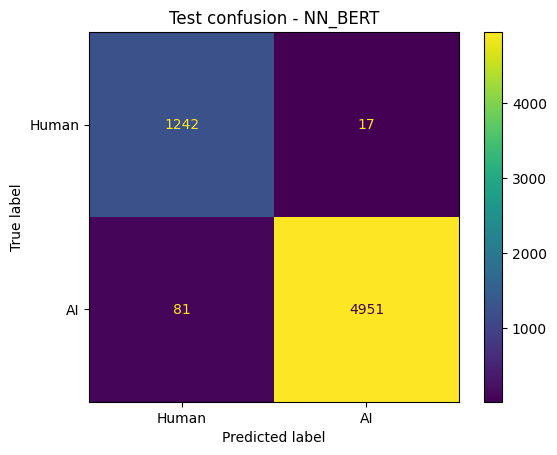

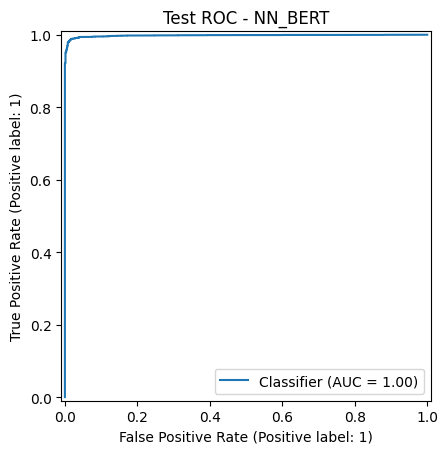

In [19]:
# Best overall by VAL (simple): plot confusion + ROC + errors
best_name, best_val = pick_best_by_val_simple(results)
print("Best overall by VAL:", best_name, "|", best_val)

best = results[best_name]
plot_confusion(best["cm_test"], title=f"Test confusion - {best_name}")
plot_roc(yte, np.asarray(best["test_score"]).ravel(), title=f"Test ROC - {best_name}")